Analiza składowych głównych (ang. principal component analysis, PCA) polega na rzutowaniu danych na nową przestrzeń, w której poszczególne składowe są względem siebie ortogonalne. Nowe składowe są kombinacją liniową (sumą ważoną) analizowanych zmiennych.

PCA jest wykorzystywane w różnych celach:
- redukcji wymiarowości,
- kompresji sygnałów,
- eksploracji danych i klasteryzacji.

Na początek rozważmy prosty, nieakustyczny przykład. Skorzystamy ze zbioru danych zawierającego informacje o czterech cechach trzech gatunków irysów, który jest wbudowany w bibliotekę scikit-learn. Te cechy to długość i szerokość dwóch rodzajów płatków - sepali i petali.

Od razu przeprowadzimy standaryzację danych, ponieważ PCA jest wrażliwe na rząd wielkości danych i bez standaryzacji wyniki mogą wyjść dużo gorsze. W dokumentacji scikit-learn jest dobry przykład co się może stać, jeżeli zapomnimy o standaryzacji: https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html#sphx-glr-auto-examples-preprocessing-plot-scaling-importance-py

In [170]:
from sklearn import datasets
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import time
iris = datasets.load_iris()
X = iris.data
y = iris.target
X = StandardScaler().fit_transform(X) #standaryzacja danych

Dane są 4D, więc nie da się ich w łatwy sposób zwizualizować. Najprościej byłoby narysować wykres 3D, a czwarty wymiar oznaczyć kolorami, ale nie byłoby to zbyt czytelne, więc na razie pominiemy wykresy. Możemy jednak dane dodać do tabeli i wyświetlić ją oraz sprawdzić, jakie klasy występują w zbiorze (co prawda wiemy, że 3, ale warto to sprawdzić, jeżeli nie my tworzyliśmy zbiór danych - ktoś mógł się pomylić przy tworzeniu labeli lub przez przypadek dodać jakieś inne obiekty)

In [171]:
print(pd.DataFrame(np.hstack((X,y[:, np.newaxis])),
                columns=['sepal length', 'sepal width', 'petal length', 
                         'petal width', 'target numerical', 
                        ]))
print(np.unique(y)) #unikalne wartości w wektorze y - można tak sprawdzić, ile klas jest w zbiorze danych 
                    #i jak są one oznaczone

     sepal length  sepal width  petal length  petal width  target numerical
0       -0.900681     1.019004     -1.340227    -1.315444               0.0
1       -1.143017    -0.131979     -1.340227    -1.315444               0.0
2       -1.385353     0.328414     -1.397064    -1.315444               0.0
3       -1.506521     0.098217     -1.283389    -1.315444               0.0
4       -1.021849     1.249201     -1.340227    -1.315444               0.0
..            ...          ...           ...          ...               ...
145      1.038005    -0.131979      0.819596     1.448832               2.0
146      0.553333    -1.282963      0.705921     0.922303               2.0
147      0.795669    -0.131979      0.819596     1.053935               2.0
148      0.432165     0.788808      0.933271     1.448832               2.0
149      0.068662    -0.131979      0.762758     0.790671               2.0

[150 rows x 5 columns]
[0 1 2]


Teraz możemy przejść do zastosowania PCA i wyznaczenia składowych głównych. Gdybyśmy chcieli wykorzystywać PCA do redukcji wymiarowości, a potem klasyfikacji w oparciu o nowe składowe, to trzeba podzielić dane na zbiór uczący i testowy, a dopiero potem zrobić PCA.

In [172]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [173]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2) #bierzemy dwie składowe, żeby łatwo było zwizualizować wyniki
principal_components_train = pca.fit_transform(X_train)
principal_components_test = pca.transform(X_test)

In [174]:
principal_components_train.shape

(112, 2)

In [175]:
pca_df = pd.DataFrame(data = (np.hstack((principal_components_train, y_train[:, np.newaxis]))),
             columns = ['PC1', 'PC2', 'target numerical'])

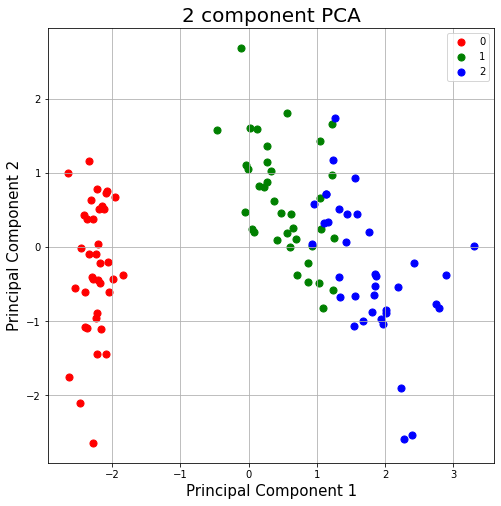

In [176]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0,1,2]
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = pca_df['target numerical'] == target
    ax.scatter(pca_df.loc[indicesToKeep, 'PC1']
               , pca_df.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

Co sądzisz o powyższym wykresie? Czy dwie składowe wystarczają do poprawnego odróżnienia od siebie wszystkich trzech gatunków?

Możemy też sprawdzić, jaki procent zmienności jest wyjaśniany przez poszczególne składowe. To nam pomoże w podjęciu decyzji, ile składowych jest potrzebnych.

Zasada jest taka, że pierwsza składowa zawsze wyjaśnia największą część zmienności, a każda kolejna coraz mniejszą.

In [177]:
pca.explained_variance_ratio_

array([0.73799433, 0.22216601])

Z powyższych wartości wynika, że pierwsza składowa wyjaśnia ok. 74% zmienności, a druga ok. 22%. Pozostałe ok. 4% są wyjaśniane przez dalsze składowe.

Jeżeli stosujemy PCA do redukcji wymiarowości, to zawsze będziemy musieli odrzucić część składowych i nowe parametry opisujące obiekty (bazujące na wybranych składowych głównych) nigdy nie będą wyjaśniać całej zmienności zawartej w oryginalnym zbiorze danych.

Teraz spróbuj zastosować PCA do redukcji wymiarowości danych akustycznych.

Na początek wyekstrahuj 13 MFCC oraz policz ich pierwszą i drugą pochodną (ponieżej jest fragment kodu pokazujący, jak to zrobić) z dowolnego sygnału z poprzednich zajęć. Pierwsza pochodna jest określana jako delta, a druga jako delta^2 lub czasem delta delta (często 
oznaczane odpowiednimi symbolami greckimi).

In [178]:
import librosa
import librosa.display
from sklearn import tree
from os import listdir
pliki = listdir('dane_testowe/')
pliki = ['dane_testowe/'+x for x in pliki]
pliki.sort()

x, fs = librosa.load(pliki[0])
mfcc_features = librosa.feature.mfcc(x, sr=fs, n_mfcc=13)
mfcc_delta = librosa.feature.delta(mfcc_features)
mfcc_delta2 = librosa.feature.delta(mfcc_features, order=2)
mfcc_delta.shape

C:\Users\jakub\AppData\Local\Temp\ipykernel_6812\3851419815.py:10: FutureWarning: Pass y=[0.00058996 0.00120533 0.00134682 ... 0.00055961 0.00025699 0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc_features = librosa.feature.mfcc(x, sr=fs, n_mfcc=13)


(13, 88)

Wyświetl MFCC oraz obie pochodne, żeby zobaczyć, jak wyglądają (kod wzięty z dokumentacji: https://librosa.org/doc/main/generated/librosa.feature.delta.html)

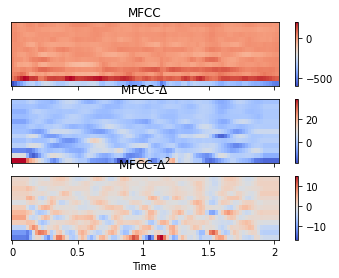

In [179]:
fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True)
img1 = librosa.display.specshow(mfcc_features, ax=ax[0], x_axis='time')
ax[0].set(title='MFCC')
ax[0].label_outer()
img2 = librosa.display.specshow(mfcc_delta, ax=ax[1], x_axis='time')
ax[1].set(title=r'MFCC-$\Delta$')
ax[1].label_outer()
img3 = librosa.display.specshow(mfcc_delta2, ax=ax[2], x_axis='time')
ax[2].set(title=r'MFCC-$\Delta^2$')
fig.colorbar(img1, ax=[ax[0]])
fig.colorbar(img2, ax=[ax[1]])
fig.colorbar(img3, ax=[ax[2]])

Wylicz MFCC oraz obie pochodne dla sygnałów z folderu dane_testowe. Pamiętaj, żeby wszystkie cechy dodać do jednej macierzy (dla każdego sygnału macierz powinna mieć wymiary 39 x liczba_ramek). Ponieważ sygnały mają różną długość, znajdź liczbę ramek najkrótszego z nich i odpowiednio skróć macierze cech pozostałych sygnałów.

In [180]:
wavs = list(map(lambda x: librosa.load(x)[0], pliki))
min_len = min(map(lambda x: x.shape[-1], wavs))
wavs = np.stack([x[0:min_len] for x in wavs])
mfccs = np.stack([librosa.feature.mfcc(x).flatten() for x in wavs])
delta = [librosa.feature.delta(x) for x in mfccs]
delta2 = [librosa.feature.delta(x, order=2) for x in mfccs]

labels = []
for i in pliki:
    if i.__contains__('phrase'):
        labels.append(1)
        continue
    labels.append(0)
mfccs.shape



C:\Users\jakub\AppData\Local\Temp\ipykernel_6812\3568094300.py:4: FutureWarning: Pass y=[0.00058996 0.00120533 0.00134682 ... 0.05039958 0.04843636 0.04549405] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = np.stack([librosa.feature.mfcc(x).flatten() for x in wavs])
C:\Users\jakub\AppData\Local\Temp\ipykernel_6812\3568094300.py:4: FutureWarning: Pass y=[-0.01685113 -0.02027931 -0.0155162  ...  0.16223633  0.16703966
  0.17554922] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = np.stack([librosa.feature.mfcc(x).flatten() for x in wavs])
C:\Users\jakub\AppData\Local\Temp\ipykernel_6812\3568094300.py:4: FutureWarning: Pass y=[0.006701   0.01092137 0.01110163 ... 0.50559765 0.47933006 0.45564932] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = np.stack([librosa.feature.mfcc(x).flatten() for x in wavs])
C:\Users\jak

(39, 720)

Podziel dane na zbiór uczący i testowy i przeprowadź klasyfikację. Wylicz też metryki.

In [181]:
def test(dane):
    X_train, X_test, Y_train, Y_test = train_test_split(dane, labels, test_size=0.2)
    clf = tree.DecisionTreeClassifier()
    clf.fit(X_train, Y_train)
    return clf.predict(X_test), Y_test

good = 0
bad = 0
test_size = 100
tic = time.perf_counter()
for i in range(0, test_size):
    p, t = test(mfccs)
    for j in range(0, len(p)):
        if p[j] == t[j]:
            good=good+1
            continue
        bad = bad+1
toc = time.perf_counter()
print('sukces mfcc: '+ str(good/(good+bad)))
print(' time: '+ str(toc-tic))

good = 0
bad = 0
test_size = 100
tic = time.perf_counter()
for i in range(0, test_size):
    p, t = test(delta)
    for j in range(0, len(p)):
        if p[j] == t[j]:
            good=good+1
            continue
        bad = bad+1
toc = time.perf_counter()
print('sukces delta: '+ str(good/(good+bad)))
print(' time: '+ str(toc-tic))

good = 0
bad = 0
test_size = 100
tic = time.perf_counter()
for i in range(0, test_size):
    p, t = test(delta2)
    for j in range(0, len(p)):
        if p[j] == t[j]:
            good=good+1
            continue
        bad = bad+1
toc = time.perf_counter()
print('sukces delta2: '+ str(good/(good+bad)))
print(' time: '+ str(toc-tic))



sukces mfcc: 0.8025
 time: 0.408098500000051
sukces delta: 0.8775
 time: 0.3438354000008985
sukces delta2: 0.89375
 time: 0.3604467000004661


Teraz na zbiorze uczącym i testowym zastosuj PCA. Na początek weź dość dużą liczbę składowych, żeby zobaczyć, ile będzie nam potrzebnych do wyjaśnienia łącznie co najmniej 90% zmienności.

In [182]:
X_train, X_test, Y_train, Y_test = train_test_split(mfccs, labels, test_size=0.2)
i = 0
ratio = 0
while ratio < 0.9:
    i = i+1
    pca = PCA(n_components=i) #bierzemy dwie składowe, żeby łatwo było zwizualizować wyniki
    principal_components_train = pca.fit_transform(X_train)
    principal_components_test = pca.transform(X_test)
    ratio = pca.explained_variance_ratio_
    ratio = sum(ratio)
    #print(i)
    #print(ratio)
print(ratio)
print(i)

0.907148209400475
14


Weź odpowiednią liczbę składowych głównych i przeprowadzić klasyfikację oraz wylicz metryki. Jak zmieniły się wyniki względem tych uzyskanych pierwszym klasyfikatorem?

In [183]:
pca = PCA(n_components=14) #bierzemy dwie składowe, żeby łatwo było zwizualizować wyniki
def test_PCA(dane):
    X_train, X_test, Y_train, Y_test = train_test_split(dane, labels, test_size=0.2)
    principal_components_train = pca.fit_transform(X_train)
    principal_components_test = pca.transform(X_test)
    clf = tree.DecisionTreeClassifier()
    clf.fit(principal_components_train, Y_train)
    return clf.predict(principal_components_test), Y_test

good = 0
bad = 0
test_size = 100
tic = time.perf_counter()
for i in range(0, test_size):
    p, t = test_PCA(mfccs)
    for j in range(0, len(p)):
        if p[j] == t[j]:
            good=good+1
            continue
        bad = bad+1
toc = time.perf_counter()
print('sukces mfcc: '+ str(good/(good+bad)))
print(' time: '+ str(toc-tic))

good = 0
bad = 0
test_size = 100
tic = time.perf_counter()
for i in range(0, test_size):
    p, t = test_PCA(delta)
    for j in range(0, len(p)):
        if p[j] == t[j]:
            good=good+1
            continue
        bad = bad+1
toc = time.perf_counter()
print('sukces delta: '+ str(good/(good+bad)))
print(' time: '+ str(toc-tic))

good = 0
bad = 0
test_size = 100
tic = time.perf_counter()
for i in range(0, test_size):
    p, t = test_PCA(delta2)
    for j in range(0, len(p)):
        if p[j] == t[j]:
            good=good+1
            continue
        bad = bad+1
toc = time.perf_counter()
print('sukces delta2: '+ str(good/(good+bad)))
print(' time: '+ str(toc-tic))

sukces mfcc: 0.92625
 time: 1.006470399999671
sukces delta: 0.96125
 time: 1.0522048000002542
sukces delta2: 0.94875
 time: 1.0319149000006291
